Thanks to [Yashas Samaga](https://github.com/YashasSamaga) OpenCV 4.2.0 DNN module has a CUDA backend for inference.  This should be really useful for C++ developers looking to run local inference in their applications.

Below is a quick example in python of how to 
1. export a previously trained fastaiv2 model to onnx and then
2. import it into OpenCV and run inference on using the CUDA backend

The timings with %timeit are comparable those detailed in the [documentation](https://gist.github.com/YashasSamaga/985071dc57885348bec072b4dc23824f).

Note: This requires OpenCV to be compiled with the CUDA backend, see [this guide](https://jamesbowley.co.uk/accelerate-opencv-4-2-0-build-with-cuda-and-python-bindings/) or download pre-compiled binaries for Anaconda with python 3.7 from [here](https://jamesbowley.co.uk/downloads/).

Run the following to install OpenCv python binaries downloaded from [here](https://jamesbowley.co.uk/downloads/).

In [1]:
import os
from pathlib import Path
import site
from shutil import copy

dir_containing_opencvworld420_dll = Path(
    DLOAD_LOC/'install/x64/vc16/bin/')
copy(dir_containing_opencvworld420_dll/'../../../python/python3/cv2.cp37-win_amd64.pyd', 
         site.getsitepackages()[1])
os.environ['PATH'] = str(dir_containing_opencvworld420_dll) + ";" + os.environ['PATH']

In [2]:
import cv2 as cv
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.notebook.showdoc import *
from IPython.core.display import display, HTML

display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

def sigmoid(x):
    return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x)))
def softmax(x):
    z = x - x.max()
    return np.exp(z)/np.exp(z).sum()

#model = resnet34
model = xresnet50_deep
#model = xresnet50_deeper
use_bce = True

## Fastai model init for comparisson

In [3]:
num_workers = 0 # windows
pat = r'\\([^\\]+)_\d+.jpg$' # windows
bs = 64
seed = 2
valid_pct = 0.2
test_pct = 0.2
n_wild_classes = 2
path = untar_data(URLs.PETS)
path_img = path/'images'
item_tfms=Resize(224)
batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize(*imagenet_stats)]

def create_dbunch(cat_block,valid_pct,seed,label_func,fnames,path,item_tfms,bs,num_workers,batch_tfms):
    dblock = DataBlock(blocks=(ImageBlock, cat_block),
                   splitter=RandomSplitter(valid_pct, seed=seed),
                   get_y=label_func)
    return DataBunch.from_dblock(dblock, fnames, path=path, item_tfms=item_tfms,bs=bs,
                                  num_workers=num_workers, batch_tfms=batch_tfms)
# MultiCategoryBlock expects a list of labels 
# https://forums.fast.ai/t/how-to-use-bcewithlogitslossflat-in-lesson1-pets-ipynb/59146
class RegextraLabeller():
    "Label `item` with regex `pat`."
    def __init__(self, pat): self.pat = re.compile(pat)
        
    def __call__(self, o, **kwargs):
        res = self.pat.search(str(o))
        assert res,f'Failed to find "{self.pat}" in "{o}"'
        return [res.group(1)]

In [4]:
fnames = get_image_files(path_img)
labeller = RegexLabeller(pat)
y_string = list(map(labeller, fnames))
vocab,o2i = uniqueify(y_string, sort=True, bidir=True)
y = np.array(list(map(o2i.get,y_string)))
i_wild_classes =  [29, 15]
mask = np.full(len(y), False)
for i in i_wild_classes: mask = mask | (y == i)
fnames_wild = [fname for (fname,mask_val) in zip(fnames, mask) if mask_val]
fnames_pets = [fname for (fname,mask_val) in zip(fnames, mask) if not mask_val]
i_trn_val,i_test = RandomSplitter(valid_pct=test_pct,seed=seed)(fnames_pets)
fnames_test = [fnames_pets[i] for i in i_test]
fnames_train_valid = [fnames_pets[i] for i in i_trn_val]
i_wild_classes =  [29, 15] 
if use_bce:
    block = MultiCategoryBlock
    label_func = RegextraLabeller(pat)
else:
    block = CategoryBlock
    label_func = RegexLabeller(pat)
dbunch = create_dbunch(block,valid_pct,seed,label_func,fnames_train_valid,path,item_tfms,bs,num_workers,
                       batch_tfms)
learn = cnn_learner(dbunch, model, metrics=error_rate)

In [5]:
if use_bce:
    save_stem = f'{model.__name__ }_bce_ex_{"_".join(map(str, i_wild_classes))}'
else:
    save_stem = f'{model.__name__ }_ce_ex_{"_".join(map(str, i_wild_classes))}'
onnx_name = save_stem + '.onnx'
save_name = save_stem + '_2'
learn.load(save_name);

## Export model to onnx

In [6]:
learn.model.eval();
dummy_input = torch.randn(1, 3, 224, 224).cuda()
torch.onnx.export(learn.model, dummy_input, onnx_name,
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'])

## Image

In [7]:
img_path = 'test_img.png'
img_tmp = cv.imread(str(fnames_wild[0]))
img_tmp = cv.resize(img_tmp,(224,224))
cv.imwrite(img_path,img_tmp);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


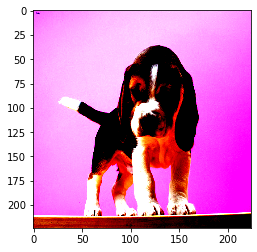

In [8]:
img = cv.cvtColor(cv.imread(str(img_path)),cv.COLOR_BGR2RGB)
#img = cv.resize(img,(224,224),interpolation= cv.INTER INTER_CUBIC)
img_normalized = (((np.array(img)/255) - imagenet_stats[0]) / imagenet_stats[1]).astype('float32')
plt.imshow(img_normalized);

## Inference Comparisson

### Pytorch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


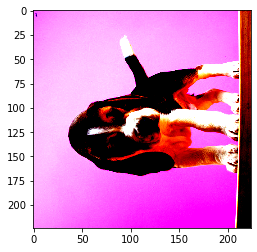

In [9]:
img_tensor = torch.from_numpy(img_normalized.transpose(1,0,2)).cuda().unsqueeze(dim=3).permute(3,2,1,0)
plt.imshow(np.array(img_tensor.squeeze().permute(2,1,0).cpu()));

In [10]:
act_pytorch = learn.model(img_tensor)
if use_bce:
    pred_pytorch = sigmoid(act_pytorch.detach().cpu().numpy())
else:
    pred_pytorch = softmax(act_pytorch.detach().cpu().numpy())
pred_pytorch

array([[1.4282933e-03, 6.1049766e-05, 2.7004164e-04, 2.5784093e-04,
        1.8659623e-03, 2.1737088e-04, 4.6354933e-05, 3.8464466e-04,
        3.4010576e-04, 1.7111718e-04, 6.4903259e-04, 8.9926451e-02,
        9.5208837e-03, 4.2087500e-04, 4.5402578e-01, 1.9247895e-04,
        1.4568870e-04, 2.1196392e-03, 3.2681943e-04, 2.9286119e-04,
        3.8284756e-04, 3.6404170e-05, 3.6079946e-05, 4.0425675e-04,
        7.0022186e-05, 4.8953755e-04, 1.3115756e-04, 1.6785794e-05,
        5.7421550e-03, 1.7254901e-04, 1.1602639e-04, 1.9136578e-04,
        1.1812403e-03, 7.1297618e-05, 1.1422704e-05]], dtype=float32)

In [11]:
%timeit -n 100 learn.model(img_tensor)

23.7 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Fastai

In [12]:
#outputs= []
#def hook(module, input, output):
#    outputs.append(output)
#learn.model[1][8].register_forward_hook(hook)
pred_fastai = learn.predict(img_path);pred_fastai

((#0) [],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False]),
 tensor([1.4282e-03, 6.1048e-05, 2.7003e-04, 2.5783e-04, 1.8659e-03, 2.1736e-04,
         4.6353e-05, 3.8464e-04, 3.4011e-04, 1.7111e-04, 6.4901e-04, 8.9922e-02,
         9.5210e-03, 4.2088e-04, 4.5402e-01, 1.9247e-04, 1.4569e-04, 2.1196e-03,
         3.2682e-04, 2.9286e-04, 3.8284e-04, 3.6404e-05, 3.6080e-05, 4.0425e-04,
         7.0020e-05, 4.8951e-04, 1.3115e-04, 1.6785e-05, 5.7420e-03, 1.7254e-04,
         1.1602e-04, 1.9136e-04, 1.1812e-03, 7.1294e-05, 1.1422e-05]))

### OpenCV

In [13]:
net = cv.dnn_ClassificationModel(onnx_name)

In [14]:
net.setInputSize(224, 224)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)
act_opencv = net.predict(img_normalized)[0]
if use_bce:
    pred_opencv = sigmoid(act_opencv)
else:
    pred_opencv = softmax(act_opencv)
pred_opencv

array([[1.4282954e-03, 6.1049534e-05, 2.7004164e-04, 2.5784021e-04,
        1.8659588e-03, 2.1737129e-04, 4.6354933e-05, 3.8464539e-04,
        3.4010463e-04, 1.7111668e-04, 6.4903230e-04, 8.9925870e-02,
        9.5208837e-03, 4.2087460e-04, 4.5402610e-01, 1.9247840e-04,
        1.4568897e-04, 2.1196392e-03, 3.2681850e-04, 2.9286006e-04,
        3.8284756e-04, 3.6404032e-05, 3.6079775e-05, 4.0425541e-04,
        7.0022259e-05, 4.8953824e-04, 1.3115705e-04, 1.6785731e-05,
        5.7421336e-03, 1.7254884e-04, 1.1602651e-04, 1.9136505e-04,
        1.1812369e-03, 7.1297545e-05, 1.1422671e-05]], dtype=float32)

In [15]:
(np.linalg.norm(act_opencv - act_pytorch.detach().cpu().numpy()),
np.linalg.norm(pred_opencv - np.array(pred_fastai[2])))

(1.6503735e-05, 7.016717e-06)

## Benchmarks

In [16]:
net = cv.dnn_ClassificationModel(onnx_name)
net.setInputSize(224, 224)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
%timeit -r 1 -n 5 net.predict(img_normalized) # warm up
%timeit net.predict(img_normalized) # cpu

71.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
54 ms ± 860 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
net = cv.dnn_ClassificationModel(onnx_name)
net.setInputSize(224, 224)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_OPENCL)
%timeit -r 1 -n 5 net.predict(img_normalized) # warm up
%timeit net.predict(img_normalized) # opencl nvidia gpu

111 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
42.8 ms ± 78.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
net = cv.dnn_ClassificationModel(onnx_name)
net.setInputSize(224, 224)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_OPENCL_FP16)
%timeit -r 1 -n 5 net.predict(img_normalized) # warm up
%timeit net.predict(img_normalized) # opencl nvidia gpu fp16

79.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
43.1 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)
%timeit -r 1 -n 5 net.predict(img_normalized) # warm up
%timeit -n 100 net.predict(img_normalized) # cuda

86.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
4.7 ms ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA_FP16)
%timeit -r 1 -n 5 net.predict(img_normalized) # warm up
%timeit -n 100 net.predict(img_normalized) # cuda fp16

97 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
3.65 ms ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
